
# Project: Investigate TMDB Movie Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## Introduction


In this report, I am going to demonstrate my investigations and findings on the TMDB movie dataset by answering a set of questions. 

### Assumptions
1. According to the [TMDB Movie Data metadata page](https://www.kaggle.com/tmdb/tmdb-movie-metadata), actors are listed in the descending order of how much they billed. Therefore I had used the first listed name as the leading actor for each movie in the 'cast' column to analyse the correlation between popularity and the actor, and to analyse the correlation between revenue and the actor. 

2. I will use imdb_id as the primary key of each movie. Therefore empty imdb_id or duplicate imdb_id will be considered as bad data and will be removed in the <a href="#cleaning">data cleaning</a> process.

3. I will assume values of zero in `revenue` and `popularity` columns as missing. Therefore in <a href="#cleaning">Data Cleaning</a> section I will remove these rows from my datasets.

### Questions to be Answered
Here is the list of questions I am going to find answers for:

1. What was the average revenue of all movies in each particular year? is there any trend across all years?
2. Grouping movies by actor, for all movies the particular actor had played the leading role, what was the average revenue? How do these statistics compare to the average revenue of all movie population? 
3. Grouping movies by actor, for all movies the particular actor had played the leading role, what was the average popularity? How do these statistics compare to the average popularity of all movie population? 
4. In general how is popularity and revenue related?

### DataFrame Instances to be Generated
In order to answering the above questions, I am going to create a set of new DataFrame instances:
1. `movies_df_original`: the original DataFrame instance where all data in the csv file will be loaded into.
2. `movies_df_imdb_id_cleaned`: the DataFrame instance without rows where `imdb_id = NaN` or `imdb_id` is duplicated.
3. `movies_df_revenue`: the DataFrame instance generated from `movies_df_imdb_id_cleaned` without rows where `revenue` field is 0.
4. `movies_df_pop`: the DataFrame instance generated from `movies_df_imdb_id_cleaned` without rows where `popularity` field is 0.
5. `movies_df_actor`: the DataFrame instance generated from `movies_df_imdb_id_cleaned` without rows where `cast` field is NaN.

These DataFrame instances will be used in <a href="#eda">Exploratory Data Analysis</a> section.




In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import pandas as pd
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', -1)

# # Defining format of float number:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np
np.set_printoptions(threshold=np.nan)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)
%matplotlib inline

import seaborn as sns

import unicodecsv

### to make sure all outputs will be displayed rather than only the output for the last expression.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"





<a id='wrangling'></a>
## Data Wrangling


### General Properties

In the below cell, I am going to load the csv file and print the top 5 rows and the data type of each column:

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
movies_df_original = pd.read_csv('tmdb-movies.csv')
movies_df_original.dtypes


id                      int64  
imdb_id                 object 
popularity              float64
budget                  int64  
revenue                 int64  
original_title          object 
cast                    object 
homepage                object 
director                object 
tagline                 object 
keywords                object 
overview                object 
runtime                 int64  
genres                  object 
production_companies    object 
release_date            object 
vote_count              int64  
vote_average            float64
release_year            int64  
budget_adj              float64
revenue_adj             float64
dtype: object

In [3]:
### This will return me the total number of rows and columns in the dataset
print ('Number of rows and columns in the original movie dataset: %s' % movies_df_original.shape[0])

### Next I want to see the count of non-NaN rows of each column
print ('Number of non-NaN rows in each column:')
movies_df_original.count()

Number of rows and columns in the original movie dataset: 10866
Number of non-NaN rows in each column:


id                      10866
imdb_id                 10856
popularity              10866
budget                  10866
revenue                 10866
original_title          10866
cast                    10790
homepage                2936 
director                10822
tagline                 8042 
keywords                9373 
overview                10862
runtime                 10866
genres                  10843
production_companies    9836 
release_date            10866
vote_count              10866
vote_average            10866
release_year            10866
budget_adj              10866
revenue_adj             10866
dtype: int64

The output shows that there are 10856 rows in the dataset that the `imdb_id` is not `NaN`, wheras there are 10866 rows in total. This means that there are 10 rows whose `imdb_id` is `NaN`. 

Since later on when I am analysing the correlation between popularity/revenue and actors, I will use `imdb_id` as the unique key to join datasets, I do not want `imdb_id` to be `NaN`. So in the I will remove these rows and return a new DataFrame object `movies_df_imdb_id_cleaned` later on in the <a href="#cleaning">Data Cleaning</a> section.

Now I am curious to see ignoring the `NaN` imdb_id, if there are duplicate imdb_id:

In [4]:
movies_df_original.groupby('imdb_id').filter(lambda x: len(x) > 1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
2089,42194,tt0411951,0.596,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian Anthony Dale|Luke Goss,NaN,Dwight H. Little,Survival is no game,martial arts|dystopia|based on video game|martial arts tournament,"In the year of 2039, after World Wars destroy much of the civilization as we know it, territories are no longer run by governments, but by corporations; the mightiest of which is the Mishima Zaibatsu. In order to placate the seething masses of this dystopia, Mishima sponsors Tekken, a tournament in which fighters battle until only one is left standing.",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.000,2010,30000000.000,967000.000
2090,42194,tt0411951,0.596,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian Anthony Dale|Luke Goss,NaN,Dwight H. Little,Survival is no game,martial arts|dystopia|based on video game|martial arts tournament,"In the year of 2039, after World Wars destroy much of the civilization as we know it, territories are no longer run by governments, but by corporations; the mightiest of which is the Mishima Zaibatsu. In order to placate the seething masses of this dystopia, Mishima sponsors Tekken, a tournament in which fighters battle until only one is left standing.",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.000,2010,30000000.000,967000.000


The output shows that imdb_id tt0411951 has a duplicate row. Here I assumed that since the two lines have the same imdb_id, the whole rows should be exactly the same. So in <a href="#cleaning">Data Cleaning</a> section I will remove this duplicated row from `movies_df_imdb_id_cleaned`.

Since I am interested in the revenue for each year, correlation between the revenue with who is acting in the movie, and the correlation between the popularity with who is acting in the movie, I am going to have a look in `revenue`, `popularity`, `cast` and `release_year` columns and find if there are any data required to be cleaned:

In [5]:

len(movies_df_original[movies_df_original['revenue'] == 0])
len(movies_df_original[movies_df_original['popularity'] == 0])
len(movies_df_original[movies_df_original['cast'].isnull()])
len(movies_df_original[movies_df_original['director'].isnull()])
len(movies_df_original[movies_df_original['vote_average'] == 0])
len(movies_df_original[movies_df_original['release_year'] == 0])
movies_df_original['release_year'].min()
movies_df_original['release_year'].max()



6016

0

76

44

0

0

1960

2015

The outputs show that in `revenue` column, the count of 0s is 6016; in `cast` column, the count of `NaN` is 76; and in `director` column, the count of `NaN` is 44. Therefore in <a href="#cleaning">Data Cleaning</a> section, I will need to removed these rows from and generate new DataFrame instances without these rows.

<a id='cleaning'></a>
### Data Cleaning

In summay, in this section I will demonstrate the process of:
1. Removing rows from the original dataset `movies_df_original` where `imdb_id` is `NaN` and generate new dataset `movies_df_imdb_id_cleaned`.
2. From `movies_df_imdb_id_cleaned` removing rows where `imdb_id` is duplicated.
3. Creating a new dataset `movies_df_revenue` from `movies_df_imdb_id_cleaned` where rows that `revenue` field is not zero. This new dataset will be used to analyse the average revenue of each particular year and its trend. This dataset will also be used for analysing the correlation between revenue and actor. Columns in the dataset are: `imdb_id`, `original_title`, `revenue` and `release_year`.
4. Creating a new dataset `movies_df_pop` from `movies_df_imdb_id_cleaned` where rows that `popularity` field is not zero. This new dataset will be used for analysing the correlation between popularity and actor. Columns in the dataset are: `imdb_id`, `original_title` and `popularity`.
5. Creating a new dataset `movies_df_actor` from `movies_df_imdb_id_cleaned` where rows that `cast` field is not `NaN`. Note that only the first actor listed will be selected. Columns in the dataset are: `imdb_id`, `original_title` and `actor`.

In [6]:
#1. Removing rows from the original dataset movies_df_original where imdb_id is NaN and generate new dataset movies_df_imdb_id_cleaned.
#Firstly returning all rows where `imdb_id` = `NaN`:
movies_df_original[movies_df_original['imdb_id'].isnull()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
548,355131,NaN,0.108,0,0,Sense8: Creating the World,Tuppence Middleton|Bae Doona |Brian J. Smith|Aml Ameen|Jamie Clayton,NaN,NaN,NaN,sexuality|superhuman|superpower|making of|social issues,NaN,25,Documentary|Science Fiction,Netflix,8/10/15,12,7.500,2015,0.000,0.000
997,287663,NaN,0.330,0,0,Star Wars Rebels: Spark of Rebellion,Freddie Prinze Jr.|Vanessa Marshall|Steve Blum|Tiya Sircar|Taylor Gray,NaN,Steward Lee|Steven G. Lee,NaN,NaN,"A Long Time Ago In A Galaxy Far, Far Awayâ€¦ Against the might of the Galactic Empire, an unlikely band of heroes emerges to renew the fight for freedom. Five years before the events of Star Wars Episode IV: A New Hope, the reigning evil Empire continues to tighten its grip of power and fear throughout the cosmos. But even amidst the tyranny and oppression of these dark days, a glimmer of light emerges. Meet the ragtag crew of the starship Ghost: Twiâ€™lek pilot Hera, street-smart pickpocket Ezra, team leader Kanan, alien enforcer Zeb, explosives expert Sabine, and Chopper, the cantankerous Droid. Together, they embark on action-packed adventures, battle ruthless villains, and ignite the very first Spark Of Rebellion against a surging tide of Stormtroopers, TIE fighters and the mysterious Inquisitor.",44,NaN,NaN,10/3/14,13,6.800,2014,0.000,0.000
1528,15257,NaN,0.608,0,0,Hulk vs. Wolverine,Fred Tatasciore|Bryce Johnson|Steve Blum|Nolan North|Michael Adamthwaite,NaN,Frank Paur,NaN,marvel comic|superhero|wolverine|hulk|norse mythology,"Department H sends in Wolverine to track down a mysterious beast known by the US Military as the Hulk, who is rampaging across the Canadian wilderness. Surveying the extent of the damage to a destroyed town, Wolverine notices a toxic scent as well as the smell of gunpowder. He is then deployed to the wilderness to resume tracking the creature.",38,Animation|Action|Science Fiction,Marvel Studios,1/27/09,38,6.900,2009,0.000,0.000
1750,101907,NaN,0.257,0,0,Hulk vs. Thor,Graham McTavish|Fred Tatasciore|Matthew Wolf|Jay Brazeau|Grey Griffin,NaN,Sam Liu,A Battle Between God and Monster,marvel comic|superhero|hulk|norse mythology|superhuman strength,"For ages, Odin has protected his kingdom of Asgard. But every winter, the All-Father must rest and regain his strength for one week. During this time, all of Asgard's foes (including trolls, giants, dark elves, and demons) try to claim the realm for their own, but they are always stopped by Odin's son, the mighty Thor, albeit with the loss of many brave Asgardian warriors. Loki, god of mischief, has kidnapped Dr. Bruce Banner and brought him to Asgard with the help of Amora, once Thor's lover, now the supervillain known as the Enchantress. Loki makes Banner angry and he changes into the Hulk. The Enchantress then casts a spell over the Hulk which separates Banner from his monstrous alter-ego and grants Loki control over the Hulk's body.",41,Action|Animation|Fantasy|Science Fiction,Marvel Studios,1/27/09,38,6.400,2009,0.000,0.000
2401,45644,NaN,0.068,0,0,Opeth: In Live Concert At The Royal Albert Hall,"Mikael Ã…kerfeldt|Martin ""Axe"" Axenrot|Martin Mendez|Per Wiberg|Fredrik Ã…kesson",http://www.opeth.com,NaN,"The Loyal Disharmonic Orchestra, Conducted By The Powers That Be",NaN,"As part of the ongoing celebration of their 20th anniversary, Sweden's Opeth is releasing live footage from the band's recent performance at London's Royal Albert Hall. 'In Live Concert at the Royal Albert Hall' is a fierce testament to Opeth's continued success in the progressive metal community. Opeth performed two sets that evening - the first of the classic, 'Blackwater Park' in its entirety and the second, a chronologically arranged selection of material from the rest of Opeth's catalogue. Bonus DVD features include an exclusive interview and 

In [7]:
#Now drop all rows whose imdb_id is NaN (10 rows) and return a new DataFrame instance movies_df_imdb_id_cleaned:
movies_df_imdb_id_cleaned = movies_df_original.dropna(subset=['imdb_id'])

#Check if rows are dropped. The output should return nothing:
movies_df_imdb_id_cleaned[movies_df_imdb_id_cleaned['imdb_id'].isnull()]

#Check count of non-NaN rows of each column of movies_df_imdb_id_cleaned and confirm NaN rows of imdb_id column are deleted:
movies_df_imdb_id_cleaned.count()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj


id                      10856
imdb_id                 10856
popularity              10856
budget                  10856
revenue                 10856
original_title          10856
cast                    10780
homepage                2934 
director                10816
tagline                 8039 
keywords                9369 
overview                10853
runtime                 10856
genres                  10835
production_companies    9831 
release_date            10856
vote_count              10856
vote_average            10856
release_year            10856
budget_adj              10856
revenue_adj             10856
dtype: int64

In [8]:
#2. From movies_df_imdb_id_cleaned removing rows where imdb_id is duplicated.
# Now from movies_df_imdb_id_cleaned, I want to check if any of the id is duplicate
(movies_df_imdb_id_cleaned.groupby('imdb_id').filter(lambda x: len(x) > 1))
# Then I will drop the second row as duplicate and keep the top row
movies_df_imdb_id_cleaned = movies_df_imdb_id_cleaned.drop_duplicates(subset='imdb_id', keep='first')

# Double-check that there is no duplicate imdb_id anymore. This should return nothing:
(movies_df_imdb_id_cleaned.groupby('imdb_id').filter(lambda x: len(x) > 1))

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
2089,42194,tt0411951,0.596,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian Anthony Dale|Luke Goss,NaN,Dwight H. Little,Survival is no game,martial arts|dystopia|based on video game|martial arts tournament,"In the year of 2039, after World Wars destroy much of the civilization as we know it, territories are no longer run by governments, but by corporations; the mightiest of which is the Mishima Zaibatsu. In order to placate the seething masses of this dystopia, Mishima sponsors Tekken, a tournament in which fighters battle until only one is left standing.",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.000,2010,30000000.000,967000.000
2090,42194,tt0411951,0.596,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian Anthony Dale|Luke Goss,NaN,Dwight H. Little,Survival is no game,martial arts|dystopia|based on video game|martial arts tournament,"In the year of 2039, after World Wars destroy much of the civilization as we know it, territories are no longer run by governments, but by corporations; the mightiest of which is the Mishima Zaibatsu. In order to placate the seething masses of this dystopia, Mishima sponsors Tekken, a tournament in which fighters battle until only one is left standing.",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.000,2010,30000000.000,967000.000


,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj


In [9]:
# Defining functions that can be used to extract data:

# return_cleaned_data_for_num_column: returning a new DataFrame instance that containing imdb_id, original_title and
# the other single column in interest, where the value of the column in interested is selecting by comparing with the passed-in 
# numerical parameter compared_value.

def return_cleaned_data_for_num_column(column_interested, compared_value):
    df_column_interested = movies_df_imdb_id_cleaned[['imdb_id', 'original_title', column_interested]].copy()
    return df_column_interested[df_column_interested[column_interested ]!= compared_value]

# return_cleaned_data_for_num_column: returning a new DataFrame instance that containing imdb_id, original_title and
# the other single non-numerical column in interest, where the value of the column in interested is selected 
# if it is not null.
def return_cleaned_data_for_char_column(column_interested):
    df_column_interested = movies_df_imdb_id_cleaned[['imdb_id', 'original_title', column_interested]].copy()
    return df_column_interested[df_column_interested[column_interested].notnull()]

# Function used to merge two tables:
def table_merge(left_table, left_table_columns, right_table, right_table_columns, on_column, how_method):
    return pd.merge(left_table[left_table_columns], right_table[right_table_columns], on=on_column, how=how_method)

# get_first_actor: returning the first actor in the cast column for each movie.
def get_first_actor(actors):
    return actors.split('|')[0]


In [29]:

#3. Creating a new dataset movies_df_revenue from movies_df_imdb_id_cleaned where rows that revenue field is zero. 
#   This new dataset will be used for analysing the correlation between revenue and actor. 
#   Columns in the dataset are: imdb_id, original_title and revenue.


movies_df_revenue = return_cleaned_data_for_num_column('revenue', 0)
movies_df_revenue = movies_df_revenue.reset_index()

# Now I will add release year column to the current revenue table:
movies_df_revenue = table_merge(movies_df_revenue, \
                                ['imdb_id', 'original_title', 'revenue'], \
                                movies_df_imdb_id_cleaned, ['imdb_id', 'release_year'], \
                                'imdb_id', \
                                'inner')

# Also shows the statistics of revenue column and store these as variables for later use.
movies_average_revenue = movies_df_revenue['revenue'].mean()
movies_revenue_std = movies_df_revenue['revenue'].std(ddof=0) # considering as population
movies_revenue_median = movies_df_revenue['revenue'].median()

In [30]:
# 4. Creating a new dataset movies_df_pop from movies_df_imdb_id_cleaned where rows that popularity field is zero. 
#    This new dataset will be used for analysing the correlation between popularity and actor. 
#    Columns in the dataset are: imdb_id, original_title and popularity.
movies_df_pop = return_cleaned_data_for_num_column('popularity', 0)
movies_df_pop.head()

# Also shows the statistics of popularity column. And store some statistics into variables for later use.
movies_average_pop = movies_df_pop['popularity'].mean()
movies_pop_std = movies_df_pop['popularity'].std(ddof=0) # considering as the population
movies_pop_median = movies_df_pop['popularity'].median()

,imdb_id,original_title,popularity
0,tt0369610,Jurassic World,32.986
1,tt1392190,Mad Max: Fury Road,28.420
2,tt2908446,Insurgent,13.113
3,tt2488496,Star Wars: The Force Awakens,11.173
4,tt2820852,Furious 7,9.335


In [12]:
# 5. Creating a new dataset movies_df_actor from movies_df_imdb_id_cleaned where rows that cast field is not NaN.
#    Note that only the first actor listed will be selected. Therefore there should not have any duplicate imdb_id in this dataset.
#    Columns in the dataset are: imdb_id, original_title and actor.
movies_df_actor = return_cleaned_data_for_char_column('cast')
movies_df_actor['cast'] = movies_df_actor['cast'].apply(get_first_actor)
movies_df_actor.head()

,imdb_id,original_title,cast
0,tt0369610,Jurassic World,Chris Pratt
1,tt1392190,Mad Max: Fury Road,Tom Hardy
2,tt2908446,Insurgent,Shailene Woodley
3,tt2488496,Star Wars: The Force Awakens,Harrison Ford
4,tt2820852,Furious 7,Vin Diesel


In [32]:
# Note movies_df_director dataset is not used for any analysis. Here I purely just have curiosity to generate this dataset.

# 6. Creating a new dataset movies_df_director from movies_df_imdb_id_cleaned where rows that director field is not NaN. 
#    Columns in the dataset are: imdb_id, director.
#    Note that all directors will be selected. Therefore there will be multiple rows with same imdb_id.
#    Referencing https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows
#                http://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/

# returning dataframe where director list is not split yet
movies_df_director_temp = return_cleaned_data_for_char_column('director')

# What the below line does:
# a. For each movie, split director list into list, where the column index of the list is starting from 0,
#    and the row index of each movie are imdb_id, original_title.
# b. Using stack() to pivot the dataframe that the innermost column index (index of each director for each movie) 
#    become the innermost row index.
#    Stack() is returning a series since imdb_id, original_title and the converted innermost row index are the new row index. 
#    And apart from the index columns, the returned object only has a single level of column lable, which is 0
director_series = pd.DataFrame(movies_df_director_temp['director'].str.split('|').tolist(),index = [movies_df_director_temp.imdb_id,movies_df_director_temp.original_title] ).stack()

# Now reset the index of the series instead of using both imdb_id and converted row index as the outer lever index
# and selecting the imdb_id and splitted director column and generating a new DataFrame instance
movies_df_director = director_series.reset_index()[['imdb_id', 'original_title', 0]]

# Now renaming the columns to be 'imdb_id' and 'director'
movies_df_director.columns = ['imdb_id', 'original_title', 'director']

<a id='eda'></a>
## Exploratory Data Analysis

Now that I have a set of datasets that denormalised and cleaned from the original dataset, and they are:
1. movies_df_revenue
2. movies_df_pop
3. movies_df_actor

Each dataset contains a subset of columns of the original dataset. I will use these datasets for my data exploration to answer the following questions:
1. What was the average revenue of all movies in each particular year? is there any trend across all years?
2. Grouping movies by actor, for all movies the particular actor had played the leading role, what was the average revenue? How do these statistics compare to the average revenue of all movie population? 
3. Grouping movies by actor, for all movies the particular actor had played the leading role, what was the average popularity? How do these statistics compare to the average popularity of all movie population? 
4. In general how is popularity and revenue related?



Firstly I will define several functions so they can be used in later analysis.

In [14]:
# Function used to group by a particular field
def group(dataset, group_by_column, sum_on_column):
    # for original_title column, concatenate rows from the same actor and get the count; for sum_on_column, get the sum
    df = dataset.groupby(group_by_column).agg({'original_title': {lambda x: (' | ').join(x), 'count'}, sum_on_column:'sum'})
    # drop the first level column lables
    df.columns = df.columns.droplevel()
    # Reset index so cast will be the column not the index and rename the column lables to be more meaningful
    df = df.reset_index()
    #df.rename(columns = {'<lambda>':'titles', 'count':'movies_count_by_actor', sum_on_column :'total_' + sum_on_column}, inplace = True)
    return df

# This function will be used to calculate the z score of a revenue against the average revenue and standard deviation 
# of all movies that has a revenue.  
def standardize_revenue(revenue):
    return (revenue - movies_average_revenue)/movies_revenue_std

# This function will be used to calculate the z score of a popularity against the average popularit and standard deviation
# of all movies that has a popularity.
def standardize_popularity(popularity):
    return (popularity - movies_average_pop)/movies_pop_std
    

## Research Question 1 What was the average revenue of all movies in each particular year? is there any trend across all years?

The first thing I am going to do in order to answer this question is to group the data by release year:

In [33]:
# Firstly I will group the data by release_year and rename columns accordingly
movies_year_revenue = group(movies_df_revenue, 'release_year', 'revenue') 
movies_year_revenue = movies_year_revenue.rename(columns = {'<lambda>': 'titles', 'revenue': 'total_revenue_this_year'})

Then I will calculate the average revenue for each year:

In [34]:
movies_year_revenue['average_revenue_this_year'] = movies_year_revenue['total_revenue_this_year']/ movies_year_revenue['count']

Next I am going to add a standardized average revenue column to compare the average revenue of each year with the average revenue of all movies:

In [35]:
movies_year_revenue['std_year_average_revenue'] = movies_year_revenue['average_revenue_this_year'].apply(standardize_revenue)

Now I want to draw two graphs. Graph 1 will show trend of total revenue of each year from 1960 to 2015. Graph 2 will show the trend of average revenue of each year from 1960 to 2015. In Graph 2, I will set the average revenue of all movies as a benchmark:

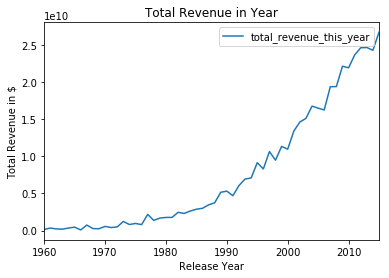

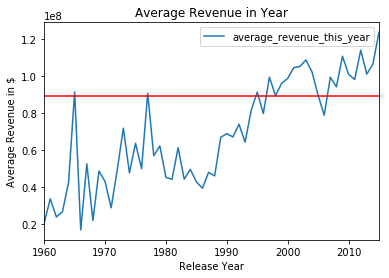

In [53]:
movies_year_revenue.plot(kind='line', x='release_year', y='total_revenue_this_year')
plt.title('Total Revenue in Year')

# Set x-axis label
plt.xlabel('Release Year')

# Set y-axis label
plt.ylabel('Total Revenue in $')

movies_year_revenue.plot(kind='line', x='release_year', y='average_revenue_this_year')
plt.axhline(y=movies_average_revenue, color='r', linestyle='-')
plt.title('Average Revenue in Year')

# Set x-axis label
plt.xlabel('Release Year')

# Set y-axis label
plt.ylabel('Average Revenue in $')

Graph 1 does not surprise me since it does make sense that the revenue is growing each year as the total movies released each year is increasing.

Graph 2 slightly surprised me as I can see the average revenue of 1965 and 1977 are obviously outliers during 1960 to 1990 period. So I am curious to see what was going on in these 2 years.

In [19]:
movies_df_revenue[movies_df_revenue['release_year'] == 1965]
movies_df_revenue[movies_df_revenue['release_year'] == 1977]

,imdb_id,original_title,revenue,release_year
4810,tt0059800,Thunderball,141195658,1965
4811,tt0059742,The Sound of Music,163214286,1965
4812,tt0059113,Doctor Zhivago,111721910,1965
4813,tt0059797,Those Magnificent Men in Their Flying Machines or How I Flew from London to Paris in 25 hours 11 minutes,29950000,1965
4814,tt0059245,The Greatest Story Ever Told,12000000,1965


,imdb_id,original_title,revenue,release_year
444,tt0076759,Star Wars,775398007,1977
445,tt0076752,The Spy Who Loved Me,185438673,1977
446,tt0076618,The Rescuers,71215869,1977
447,tt0075686,Annie Hall,38251425,1977
448,tt0075860,Close Encounters of the Third Kind,303788635,1977
449,tt0075784,A Bridge Too Far,50750000,1977
450,tt0076716,Sinbad and the Eye of the Tiger,16000000,1977
451,tt0076666,Saturday Night Fever,237113184,1977
452,tt0076141,High Anxiety,31063038,1977
453,tt0076729,Smokey and the Bandit,126737428,1977


By looking at movies released in 1965, Thunderball, The Sound of Music and Doctor Zhivago all had revenue over 100 millions, which contributed to the high average revenue in that year.

in 1977, Star War was definitely something. It earned nearly 800 millions revenue. Even there was a movie - The Sentinel - only got 3 dollars revenue in the same year, Star War revenue was just legendary enough to balance it and made this year a special movie year.

## Research Question 2 Grouping movies by actor, for all movies the particular actor had played the leading role, what was the average revenue? How do these statistics compare to the average revenue of all movie population?
To answer this question, firstly I will merge the revenue and actor table so that I can get a list of movies and its leading actor:

In [20]:
movies_actor_revenue = table_merge(movies_df_actor, ['imdb_id','cast'], movies_df_revenue, movies_df_revenue.columns, 'imdb_id', 'inner')
movies_actor_revenue['cast'].value_counts()

Nicolas Cage                 39
Robert De Niro               35
Bruce Willis                 34
Sylvester Stallone           32
Johnny Depp                  32
Tom Hanks                    30
Denzel Washington            30
Tom Cruise                   28
Clint Eastwood               27
Arnold Schwarzenegger        26
Harrison Ford                25
Robin Williams               25
Adam Sandler                 25
Eddie Murphy                 25
John Travolta                24
Kevin Costner                24
Michael Douglas              24
Jim Carrey                   23
Matt Damon                   22
Ben Stiller                  22
Mel Gibson                   22
Keanu Reeves                 22
Mark Wahlberg                20
Kurt Russell                 20
Ben Affleck                  20
Liam Neeson                  20
Al Pacino                    20
Dennis Quaid                 19
Sandra Bullock               19
George Clooney               19
                             ..
Leonard 

Then I will group by actor and aggragate the data by `sum` and `count` respectively showing the total revenue of all the movies that a particular actor had played as the leading role and the count of movies the total revenue came from. Also I will show the aggragated movie titles for each actor:

In [36]:
movies_revenue_by_actor = group(movies_actor_revenue, 'cast', 'revenue')
movies_revenue_by_actor.rename(columns = {'<lambda>':'titles', 'count':'movies_count_by_actor', 'revenue':'total_revenue'}, inplace = True)

I will then calculate the average revenue for all the movies the particular actor had played as the leading role:

In [37]:
movies_revenue_by_actor['average_revenue_by_actor'] = movies_revenue_by_actor['total_revenue']/movies_revenue_by_actor['movies_count_by_actor']

Now I am curious how the average revenue by each individual actor comparing with the average revenue of all movies:

In [38]:
movies_revenue_by_actor['std_revenue_to_all_movies'] = movies_revenue_by_actor['average_revenue_by_actor'].apply(standardize_revenue)

Now I want to add a rank column to show the rank of the standardized revenue for each actor:

In [24]:
movies_revenue_by_actor['rank_by_std_revenue'] = movies_revenue_by_actor['std_revenue_to_all_movies'].rank(method='dense',ascending=False)
movies_revenue_by_actor = movies_revenue_by_actor.sort_values('rank_by_std_revenue').reset_index(drop=True)
len(movies_revenue_by_actor)
len(movies_revenue_by_actor[movies_revenue_by_actor['std_revenue_to_all_movies']>=2])


1802

33

From the output we can see that the average revenue earn by 33 out of 1802 actors are over 2 standard deviation of the general average movie revenue.

### Research Question 3 Grouping movies by actor, for all movies the particular actor had played the leading role, what was the average popularity? How do these statistics compare to the average popularity of all movie population? 

The process will be very similar to the process of last question.
Firstly merging actor and popularity tables:

In [39]:
movies_actor_popularity = table_merge(movies_df_actor, ['imdb_id','cast'], movies_df_pop, movies_df_pop.columns, 'imdb_id', 'inner')

Then I will group by actor and aggragate the data by `sum` and `count` respectively showing the total popularity the particular actor helped to gain and the count of movies the total revenue came from. Also I will show the aggragated movie titles for each actor:

In [26]:
movies_pop_by_actor = group(movies_actor_popularity, 'cast', 'popularity')
movies_pop_by_actor.rename(columns={'<lambda>':'titles', 'count':'movies_count_by_actor', 'popularity':'total_popularity'}, inplace=True)

Next I will calculate the average popularity for all movies the particular actor had played the leading role. I will then convert the average popularity into a standardized popularity value against the average popularity of all movies. Finally I will rank the actor based on the standardized popularity:

In [40]:
movies_pop_by_actor['average_popularity_by_actor'] = movies_pop_by_actor['total_popularity'] / movies_pop_by_actor['movies_count_by_actor']
movies_pop_by_actor['std_popularity_to_all_movies'] = movies_pop_by_actor['average_popularity_by_actor'].apply(standardize_popularity)
movies_pop_by_actor['rank_by_std_popularity'] = movies_pop_by_actor['std_popularity_to_all_movies'].rank(method='dense',ascending=False)
movies_pop_by_actor = movies_pop_by_actor.sort_values('rank_by_std_popularity').reset_index(drop=True)

### Research Question 4 In general how is popularity and revenue related?
To answer this question, I will inner merge datasets `movies_df_revenue` and `movies_df_pop` and get a combined dataset shows both revenue and popularity for each movie where revenue and popularity are both not null. Then I will draw a chart to see the if there is a correlation. 

array([[ 1.        ,  0.62930486],
       [ 0.62930486,  1.        ]])

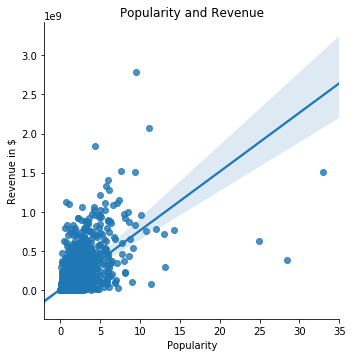

In [51]:
# table merge: movies_df_revenue and movies_df_pop
movies_revenue_pop = table_merge(movies_df_revenue, ['imdb_id','original_title', 'revenue'], movies_df_pop, ['imdb_id', 'popularity'], 'imdb_id', 'inner')

corr = np.corrcoef(movies_revenue_pop['revenue'], movies_revenue_pop['popularity'])
corr

sns.lmplot(x='popularity',y='revenue',data=movies_revenue_pop,fit_reg=True) 

# ttl = plt.gca().title
# ttl.set_position([.5, 1.05])
# plt.gca().set_title("Correlation between popularity and revenue")
plt.title('Popularity and Revenue')

# Set x-axis label
plt.xlabel('Popularity')

# Set y-axis label
plt.ylabel('Revenue in $')

The pearson's r value is 0.63 which tells us popularity and revenue have a moderate positive relationship. Then the scatter plot with the regression line helps to visualise the correalation.

<a id='conclusions'></a>
## Conclusions

In summary, I have analysed the TMDB movie dataset by answering these questions:
1. What was the average revenue of all movies in each particular year? is there any trend across all years?
2. Grouping movies by actor, for all movies the particular actor had played the leading role, what was the average revenue? How do these statistics compare to the average revenue of all movie population?
3. Grouping movies by actor, for all movies the particular actor had played the leading role, what was the average popularity? How do these statistics compare to the average popularity of all movie population?
4. In general how is popularity and revenue related?

I have found out that overall the total movie revenue earned has been increasing since 1960 to 2015. The average movie revenue for each year is also increasing. I also saw how remarkable movies (e.g. Star War) had a big impact on the average revenue in a particular year which saved the year out of other movies with low profit.

In order to answer question 2 and 3, I have created two tables to show the average revenue and average popularity respectively for all movies played by each actor. The average value then was used to compared with the average value of all movies by standardizeing the average values for each actor to the average value of all movies. It looks like Chris Pratt is definitely the winner for both revenue earning and popularity gaining. His z-score of average earned revenue and popularity are 6.505 and 22.989.

It also looks like there is a positive correlation between popularity and revenue of the movie, which means that the more popular a movie is, the more revenue it can possiblly earn.

### Limitation
Note that I only considered the first listed actor in the cast column to get my result. This means I have missed data for many other actors who also played a role in the movie. Therefore the total number of movies played by the actor and their revenue and popularity may not truely reflect the actual data that actor had played.

Also the revenue column is the column with the most missing values. If all missing values are added, the result may be changed.

Future work may include analysing the correlation between popularity and vote_average; analysing statistics for movies under each genre; and text processing on the keyword/tagline/overview columns to see what words/scentence drived people to go to the cinema and watch the movie.

<a id='reference'></a>
## References

https://www.kaggle.com/tmdb/tmdb-movie-metadata

https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

http://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/

